# MNIST–SDF → Darcy (EIT) : Forward + Inverse in 2D

This notebook builds a tiny, interpretable pipeline:

1) **Prepare geometry**: MNIST mask → Signed Distance Field (SDF) → conductivity map \(a(x)\)  
2) **Forward problem**: solve \(-\nabla\cdot(a\nabla u)=f\) with **Dirichlet BCs** (EIT/ Darcy style)  
3) **Plot**: coefficient, solution, SDF  
4) **Inverse problem**: recover \(a(x)\) from **multiple boundary-condition (BC) experiments**  
5) **Plot**: recovered vs. true \(a(x)\), and residuals

Everything runs on a 128×128 grid and uses only NumPy/SciPy/Matplotlib.


In [4]:
# === 0. Imports & small utilities ===
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.ndimage import distance_transform_edt as edt

np.set_printoptions(precision=4, suppress=True)

def percent_clip_kwargs(img, lo=1, hi=99):
    vmin, vmax = np.percentile(img, [lo, hi])
    if vmin == vmax:
        vmin, vmax = float(img.min()), float(img.max() + 1e-9)
    return dict(vmin=vmin, vmax=vmax)


## 1) Geometry → SDF → Conductivity

- **Input**: binary mask `mask` (1 inside digit, 0 outside) at 128×128  
- **SDF**: negative inside, positive outside  
- **Conductivity**: smooth mapping of SDF to \(a(x)\) (stable for derivatives & inversion)


In [6]:
# --- SDF from a binary mask (1 inside, 0 outside) ---
def sdf_from_mask(mask_uint8: np.ndarray) -> np.ndarray:
    """
    mask_uint8: (H,W) uint8 {0,1}
    returns SDF (float64), NEGATIVE inside (mask==1), POSITIVE outside
    """
    mask = mask_uint8.astype(np.uint8)
    dist_outside = edt(mask == 0)
    dist_inside  = edt(mask == 1)
    sdf = dist_outside - dist_inside  # negative inside, positive outside
    return sdf.astype(np.float64)

# --- Smooth SDF -> conductivity mapping ---
def conductivity_from_sdf(
    sdf: np.ndarray,
    a_inside: float = 1e-3,
    a_outside: float = 1.0,
    alpha: float = 40.0,
) -> np.ndarray:
    """
    Smoothly map SDF to conductivity a(x).
    Inside (sdf<0) ~ a_inside, outside ~ a_outside.
    alpha controls sharpness of transition band.
    """
    sig = 1.0 / (1.0 + np.exp(-alpha * sdf))  # ~0 inside, ~1 outside
    a = a_outside + (a_inside - a_outside) * (1.0 - sig)
    # safety clip (keeps SPD, avoids zeros)
    lo, hi = min(a_inside, a_outside)*1e-6, max(a_inside, a_outside)*1e6
    return np.clip(a, lo, hi)


In [7]:
# --- EXAMPLE: create or load your MNIST mask here ---
# mask shape must be (128,128), values {0,1}
# For demo, we create a fake "blob"; replace this with your MNIST digit mask.
H = W = 128
Y, X = np.mgrid[0:H, 0:W]
cx, cy, r = 64, 64, 28
mask = (((X-cx)**2 + (Y-cy)**2) <= r*r).astype(np.uint8)

sdf = sdf_from_mask(mask)
a_true = conductivity_from_sdf(sdf, a_inside=1e-2, a_outside=1.0, alpha=40.0)


/tmp/ipykernel_2957466/1730018683.py:25: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1.0 + np.exp(-alpha * sdf))  # ~0 inside, ~1 outside


## 2) Boundary Conditions (Dirichlet) as Functions + Tokens

We drive the PDE with non-uniform Dirichlet BCs (no interior source).  
Provide both: (a) **arrays of boundary values** for the solver, and (b) **2-channel token images** if you later train a neural operator.


In [8]:
def broadcast_vec(val, n):
    v = np.asarray(val, dtype=np.float64)
    if v.ndim == 0:
        return np.full(n, float(v))
    assert v.shape == (n,)
    return v

def make_dirichlet_bc(H, W, kind="left_right", strength=1.0, seed=None):
    """
    Returns:
      bc_arrays: (bc_left(H), bc_right(H), bc_bottom(W), bc_top(W))
      bc_tokens: (2,H,W) image with boundary values painted on edges
    """
    rng = np.random.default_rng(seed)
    bc_left   = np.zeros(H); bc_right  = np.zeros(H)
    bc_bottom = np.zeros(W); bc_top    = np.zeros(W)

    if kind == "left_right":
        bc_left[:]  = strength
        bc_right[:] = 0.0
    elif kind == "right_left":
        bc_left[:]  = 0.0
        bc_right[:] = strength
    elif kind == "top_bottom":
        bc_top[:]    = strength
        bc_bottom[:] = 0.0
    elif kind == "bottom_top":
        bc_top[:]    = 0.0
        bc_bottom[:] = strength
    elif kind == "diag1":
        # linear ramp along left/right
        y = np.linspace(0,1,H)
        bc_left  = strength * y
        bc_right = 0.0 * y
    elif kind == "stripe_lr":
        y = np.linspace(0,1,H)
        bc_left  = strength * (0.5 + 0.5*np.sin(2*np.pi*(y - 0.25)))
        bc_right = 0.0 * y
    else:
        raise ValueError(f"Unknown BC kind: {kind}")

    tok = np.zeros((2, H, W), dtype=np.float64)
    tok[0, :, 0]   = bc_left
    tok[0, :, -1]  = bc_right
    tok[1, 0, :]   = bc_bottom
    tok[1, -1, :]  = bc_top
    return (bc_left, bc_right, bc_bottom, bc_top), tok


## 3) Elliptic Solver: \(-\nabla\cdot(a\nabla u)=f\) with Dirichlet BCs

- 5-point finite differences  
- **Harmonic face averaging** for jump-aware fluxes  
- Works for any \(f\) (we’ll use \(f=0\) for boundary-driven Darcy/EIT)


In [9]:
def solve_elliptic_dirichlet(a, f, *, bc_left, bc_right, bc_bottom, bc_top):
    """
    Solve:  -div(a grad u) = f   on an HxW grid
    Dirichlet BCs given on all outer edges via arrays.
    """
    a = np.asarray(a, dtype=np.float64)
    f = np.asarray(f, dtype=np.float64)
    H, W = a.shape
    assert f.shape == (H, W)

    bc_left   = broadcast_vec(bc_left,   H)
    bc_right  = broadcast_vec(bc_right,  H)
    bc_bottom = broadcast_vec(bc_bottom, W)
    bc_top    = broadcast_vec(bc_top,    W)

    hx = 1.0/(W-1); hy = 1.0/(H-1)
    inv_hx2, inv_hy2 = 1.0/(hx*hx), 1.0/(hy*hy)

    Ni, Nj, N = H-2, W-2, (H-2)*(W-2)
    def idx(i,j): return (i-1)*Nj + (j-1)

    A = sparse.lil_matrix((N, N), dtype=np.float64)
    b = np.zeros(N, dtype=np.float64)
    eps = 1e-12

    for i in range(1, H-1):
        for j in range(1, W-1):
            k = idx(i, j)
            aC = a[i, j]
            aE = 2*aC*a[i, j+1]/(aC + a[i, j+1] + eps)
            aW = 2*aC*a[i, j-1]/(aC + a[i, j-1] + eps)
            aN = 2*aC*a[i+1, j]/(aC + a[i+1, j] + eps)
            aS = 2*aC*a[i-1, j]/(aC + a[i-1, j] + eps)

            A[k, k] = (aE + aW)*inv_hx2 + (aN + aS)*inv_hy2

            # west
            if j-1 >= 1: A[k, idx(i, j-1)] = -aW*inv_hx2
            else:        b[k] += aW*inv_hx2 * bc_left[i]
            # east
            if j+1 <= W-2: A[k, idx(i, j+1)] = -aE*inv_hx2
            else:          b[k] += aE*inv_hx2 * bc_right[i]
            # south
            if i-1 >= 1: A[k, idx(i-1, j)] = -aS*inv_hy2
            else:        b[k] += aS*inv_hy2 * bc_bottom[j]
            # north
            if i+1 <= H-2: A[k, idx(i+1, j)] = -aN*inv_hy2
            else:          b[k] += aN*inv_hy2 * bc_top[j]

            b[k] += f[i, j]

    u_int = spsolve(A.tocsr(), b)

    u = np.zeros((H, W), dtype=np.float64)
    u[:, 0]  = bc_left
    u[:, -1] = bc_right
    u[0, :]  = bc_bottom
    u[-1, :] = bc_top
    u[1:-1, 1:-1] = u_int.reshape(Ni, Nj)
    return u


## 4) Forward Sample + Plots

- choose a BC pattern  
- solve forward with \(f=0\) (boundary-driven)  
- quick sanity plots: \(a(x)\), \(u(x)\), SDF


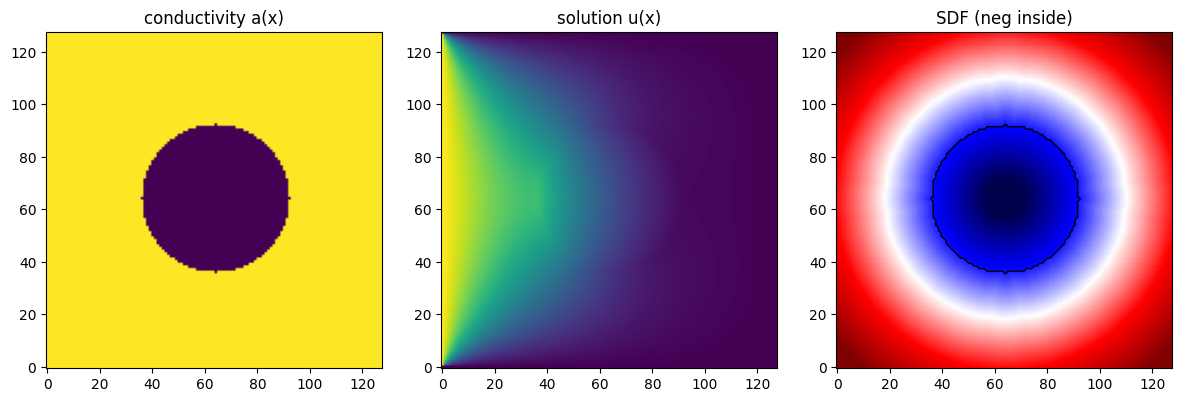

In [10]:
# Build one forward sample
bc_arrays, bc_tokens = make_dirichlet_bc(H, W, kind="left_right", strength=1.0, seed=0)
f0 = np.zeros_like(a_true)
u_obs = solve_elliptic_dirichlet(a_true, f0, bc_left=bc_arrays[0], bc_right=bc_arrays[1],
                                 bc_bottom=bc_arrays[2], bc_top=bc_arrays[3])

# Plots
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(a_true, origin="lower", **percent_clip_kwargs(a_true)); ax[0].set_title("conductivity a(x)")
ax[1].imshow(u_obs, origin="lower", **percent_clip_kwargs(u_obs)); ax[1].set_title("solution u(x)")
m = ax[2].imshow(sdf, origin="lower", cmap="seismic", **percent_clip_kwargs(sdf))
ax[2].contour(sdf, levels=[0], colors="k", linewidths=1.0); ax[2].set_title("SDF (neg inside)")
plt.tight_layout(); plt.show()


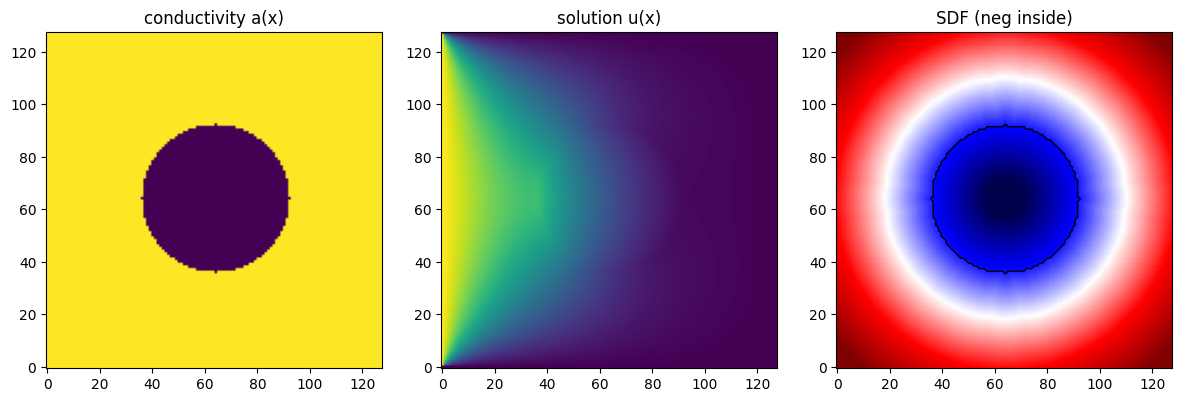

In [11]:
# Build one forward sample
bc_arrays, bc_tokens = make_dirichlet_bc(H, W, kind="left_right", strength=1.0, seed=0)
f0 = np.zeros_like(a_true)
u_obs = solve_elliptic_dirichlet(a_true, f0, bc_left=bc_arrays[0], bc_right=bc_arrays[1],
                                 bc_bottom=bc_arrays[2], bc_top=bc_arrays[3])

# Plots
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(a_true, origin="lower", **percent_clip_kwargs(a_true)); ax[0].set_title("conductivity a(x)")
ax[1].imshow(u_obs, origin="lower", **percent_clip_kwargs(u_obs)); ax[1].set_title("solution u(x)")
m = ax[2].imshow(sdf, origin="lower", cmap="seismic", **percent_clip_kwargs(sdf))
ax[2].contour(sdf, levels=[0], colors="k", linewidths=1.0); ax[2].set_title("SDF (neg inside)")
plt.tight_layout(); plt.show()


## 5) Multiple-BC “Measurements” for the Same Conductivity

To make inversion informative, generate several observations \(u^{(k)}\) with different BCs.


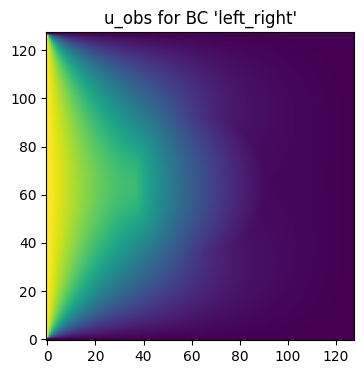

In [12]:
def make_observations_multiBC(a_true, bc_kinds, strength=1.0, seeds=None):
    H, W = a_true.shape
    if seeds is None: seeds = [None]*len(bc_kinds)
    f0 = np.zeros((H,W))
    u_obs_list, bc_list = [], []
    for kind, seed in zip(bc_kinds, seeds):
        bc_arrays, _ = make_dirichlet_bc(H, W, kind=kind, strength=strength, seed=seed)
        u = solve_elliptic_dirichlet(a_true, f0,
                                     bc_left=bc_arrays[0], bc_right=bc_arrays[1],
                                     bc_bottom=bc_arrays[2], bc_top=bc_arrays[3])
        u_obs_list.append(u)
        bc_list.append(bc_arrays)
    return u_obs_list, bc_list

bc_kinds = ["left_right", "right_left", "top_bottom", "bottom_top", "diag1", "stripe_lr"]
u_obs_list, bc_list = make_observations_multiBC(a_true, bc_kinds, strength=1.0, seeds=list(range(len(bc_kinds))))

# quick peek at one observation
plt.figure(figsize=(4.5,4)); plt.imshow(u_obs_list[0], origin="lower", **percent_clip_kwargs(u_obs_list[0]))
plt.title(f"u_obs for BC '{bc_kinds[0]}'"); plt.show()


## 6) Classical Inversion (Pixelwise \(a(x)\)) using Adjoint Gradient

We recover \(a(x)\) by minimizing
\[
J[a]=\frac{1}{K}\sum_k \tfrac12\|u^{(k)}(a)-u^{(k)}_{\text{obs}}\|_2^2 + \frac{\gamma}{2}\|\nabla a\|_2^2.
\]

**Notes**  
- Single experiment is ill-posed; multiple BCs help.  
- \(\gamma\) controls smoothness; lower → sharper but noisier.


In [13]:
# --- small finite-difference helpers for gradient & Laplacian ---
def grad_xy(F):
    H, W = F.shape
    hx = 1.0/(W-1); hy = 1.0/(H-1)
    Fx = np.zeros_like(F); Fy = np.zeros_like(F)
    Fx[:,1:-1] = (F[:,2:] - F[:,:-2])/(2*hx)
    Fy[1:-1,:] = (F[2:,:] - F[:-2,:])/(2*hy)
    return Fx, Fy

def laplacian_5pt(F):
    H, W = F.shape
    hx = 1.0/(W-1); hy = 1.0/(H-1)
    L = np.zeros_like(F)
    L[1:-1,1:-1] = (
        (F[1:-1,2:] - 2*F[1:-1,1:-1] + F[1:-1,:-2])/(hx*hx)
      + (F[2:,1:-1] - 2*F[1:-1,1:-1] + F[:-2,1:-1])/(hy*hy)
    )
    return L

# --- adjoint solve: -div(a grad p_k) = u_k - u_obs_k, homogeneous Dirichlet ---
def adjoint_solve(a, resid):
    H, W = a.shape
    zerosH = np.zeros(H); zerosW = np.zeros(W)
    return solve_elliptic_dirichlet(a, resid, bc_left=zerosH, bc_right=zerosH, bc_bottom=zerosW, bc_top=zerosW)

# --- joint inversion over multiple BCs ---
def invert_conductivity_multiBC(
    u_obs_list, bc_list, a_init,
    gamma=2e-3,  # smoothness
    a_min=1e-4, a_max=5.0,
    step0=1e-1, max_iter=60, verbose=True
):
    """
    Pixelwise inversion of a(x) from multiple BC experiments.
    Returns recovered a(x) and list of fitted u(x) per BC.
    """
    K = len(u_obs_list)
    H, W = a_init.shape
    f0 = np.zeros((H,W))
    a = np.clip(a_init.copy(), a_min, a_max)

    # helper: forward solve for all BCs
    def forward_all(a_field):
        return [solve_elliptic_dirichlet(a_field, f0, bc_left=bc[0], bc_right=bc[1], bc_bottom=bc[2], bc_top=bc[3])
                for bc in bc_list]

    # init
    u_list = forward_all(a)
    mis = sum(0.5*np.mean((u - uo)**2) for u, uo in zip(u_list, u_obs_list))/K
    gx, gy = grad_xy(a); reg = 0.5*gamma*np.mean(gx*gx + gy*gy)
    J = mis + reg
    if verbose: print(f"iter 0: J={J:.6e} mis={mis:.6e} reg={reg:.6e}")

    step = step0
    for it in range(1, max_iter+1):
        # gradient accumulation
        data_grad = np.zeros_like(a)
        for u, uo in zip(u_list, u_obs_list):
            resid = u - uo
            p = adjoint_solve(a, resid)
            ux, uy = grad_xy(u)
            px, py = grad_xy(p)
            data_grad += -(ux*px + uy*py)
        data_grad /= K
        reg_grad = -gamma * laplacian_5pt(a)
        g = data_grad + reg_grad

        # backtracking line search
        ok = False
        for _ in range(10):
            a_try = np.clip(a - step*g, a_min, a_max)
            u_try = forward_all(a_try)
            mis_try = sum(0.5*np.mean((ut - uo)**2) for ut, uo in zip(u_try, u_obs_list))/K
            gx, gy = grad_xy(a_try); reg_try = 0.5*gamma*np.mean(gx*gx + gy*gy)
            J_try = mis_try + reg_try
            if J_try <= J - 1e-4*step*np.mean(g*g):
                ok = True; break
            step *= 0.5

        if ok:
            a, u_list, J, mis, reg = a_try, u_try, J_try, mis_try, reg_try
        if verbose and (it % 5 == 0 or it == max_iter):
            print(f"iter {it}: J={J:.6e} mis={mis:.6e} reg={reg:.6e} step={step:.2e}")

    return a, u_list


## 7) Run Inversion + Plot Results

iter 0: J=7.885391e-04 mis=7.885391e-04 reg=0.000000e+00
iter 5: J=7.857533e-04 mis=7.856392e-04 reg=1.140816e-07 step=1.25e-02
iter 10: J=7.851651e-04 mis=7.849807e-04 reg=1.843119e-07 step=1.25e-02
iter 15: J=7.847414e-04 mis=7.845277e-04 reg=2.137739e-07 step=6.25e-03
iter 20: J=7.844525e-04 mis=7.842086e-04 reg=2.439141e-07 step=6.25e-03
iter 25: J=7.841690e-04 mis=7.838929e-04 reg=2.760969e-07 step=6.25e-03
iter 30: J=7.838902e-04 mis=7.835805e-04 reg=3.097401e-07 step=6.25e-03
iter 35: J=7.836160e-04 mis=7.832712e-04 reg=3.447708e-07 step=6.25e-03
iter 40: J=7.833462e-04 mis=7.829651e-04 reg=3.811223e-07 step=6.25e-03
iter 45: J=7.830807e-04 mis=7.826619e-04 reg=4.187324e-07 step=6.25e-03
iter 50: J=7.828193e-04 mis=7.823617e-04 reg=4.575430e-07 step=6.25e-03
iter 55: J=7.825619e-04 mis=7.820644e-04 reg=4.974995e-07 step=6.25e-03
iter 60: J=7.823084e-04 mis=7.817698e-04 reg=5.385506e-07 step=6.25e-03


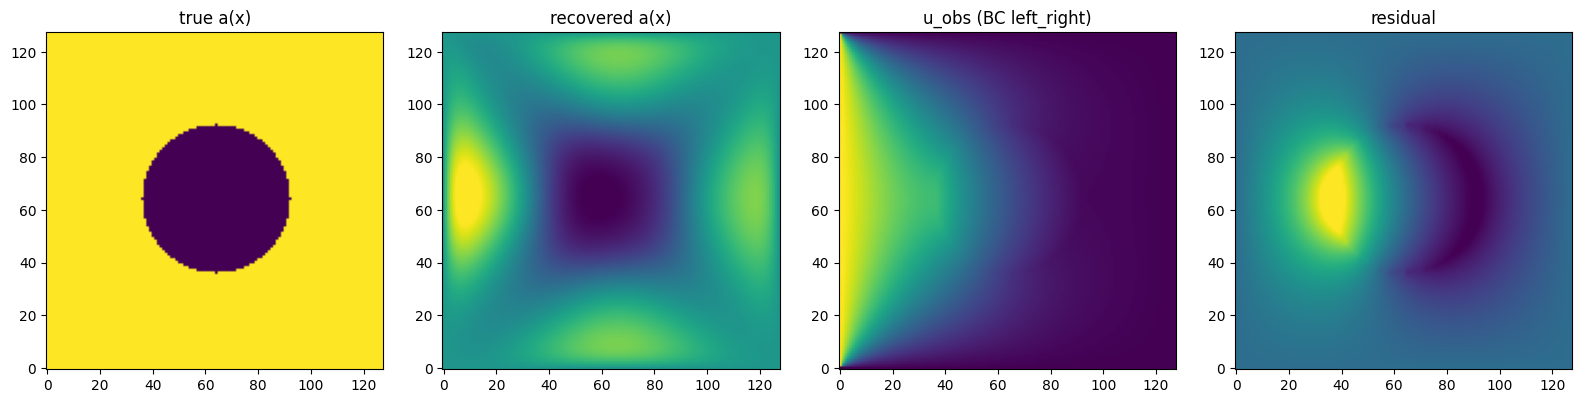

In [14]:
# Initial guess (uniform)
a_init = np.ones_like(a_true)

# Invert jointly across all BCs we generated
a_rec, u_fit_list = invert_conductivity_multiBC(
    u_obs_list, bc_list, a_init,
    gamma=2e-3, a_min=1e-4, a_max=5.0,
    step0=1e-1, max_iter=60, verbose=True
)

# Compare true vs recovered conductivity, and residual for one BC
k = 0
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(a_true, origin="lower", **percent_clip_kwargs(a_true)); ax[0].set_title("true a(x)")
ax[1].imshow(a_rec,  origin="lower", **percent_clip_kwargs(a_rec));  ax[1].set_title("recovered a(x)")
ax[2].imshow(u_obs_list[k], origin="lower", **percent_clip_kwargs(u_obs_list[k])); ax[2].set_title(f"u_obs (BC {bc_kinds[k]})")
ax[3].imshow(u_obs_list[k] - u_fit_list[k], origin="lower", **percent_clip_kwargs(u_obs_list[k]-u_fit_list[k])); ax[3].set_title("residual")
plt.tight_layout(); plt.show()


## 8) Knobs to Try

- **Contrast**: `a_inside ∈ {1e-3, 1e-2}`, `a_outside = 1.0` → stronger shape imprint  
- **BC diversity**: add `"diag1"`, `"stripe_lr"`, random left/right patterns  
- **Regularization**: lower `gamma` for sharper shapes (but watch noise)  
- **Resolution**: try 256×256 if your machine allows  
- **Noise**: add noise to `u_obs_list` to test robustness; weight the misfit accordingly
